In [1]:
# Load packages
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np
import os
import cv2 
import skimage
from skimage import exposure
from skimage import transform
from sklearn.utils import shuffle

# Set paths to training, validation, and test (pickled) data
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset?
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", X_valid.shape[0])
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


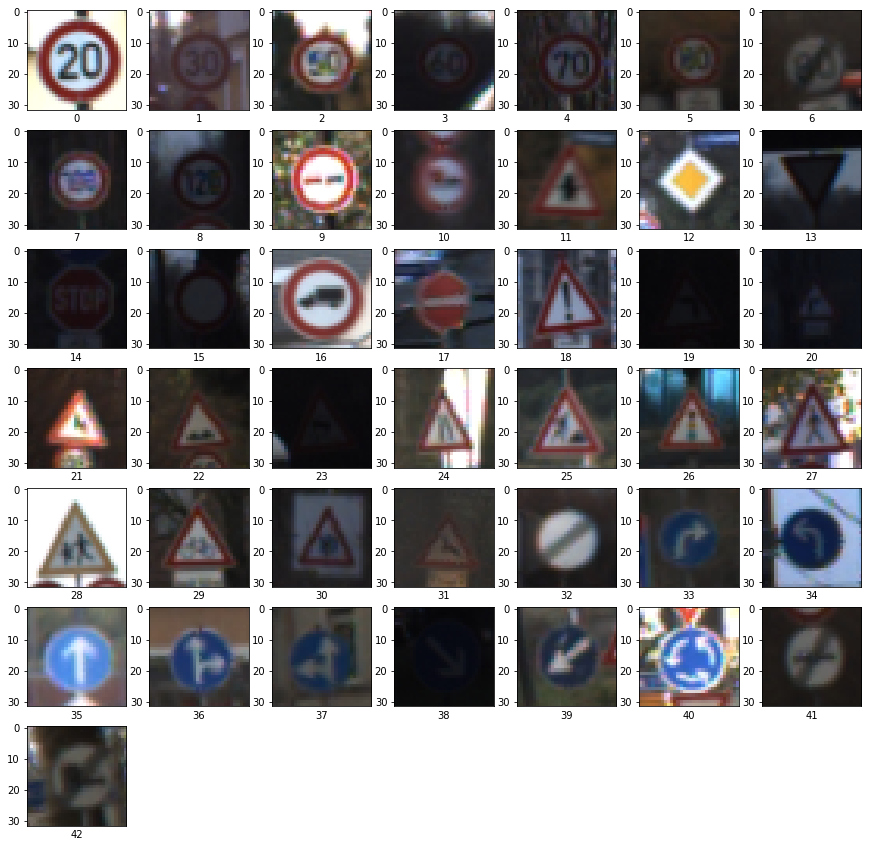

In [3]:
# Plot all the figures
fig = plt.figure(figsize = (15,15))
for i in range(n_classes):
        axes = fig.add_subplot(7,7,i+1)
        ind = np.where(y_train == i)[0][5]
        axes.imshow(X_train[ind])
        axes.set_xlabel(y_train[ind])
        plt.xticks(np.array([]))

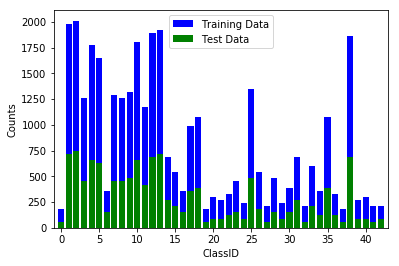

In [4]:
# Explore the training and testing dataset
_,train_counts = np.unique(y_train, return_counts = True)   # Find unique values and their counts
_,test_counts = np.unique(test['labels'], return_counts = True)   # Find unique values and their counts

# Plot histogram of different training classes 
plt.bar(range(43), train_counts, align='center',  color='b', label='Training Data')
plt.bar(range(43), test_counts, align='center',  color='g', label='Test Data')
plt.xlabel('ClassID')
plt.ylabel('Counts')
plt.xlim([-1, 43])
plt.legend()

In [5]:
def focus_ROI(img,coords,size):
    # Focus on the region of interest in each image
    # INPUT:
    # img = an image
    # coords = coordinates of the top left and bottom left corners of bounding box
    # size = size of original image
    # RETURN:
    # Image of size 32x32, focused on region of interest
    
    if (coords[1]>size[0] or coords[3]>size[0] or coords[1]>size[1] or coords[2]>size[1]):
        return img

    img0 = img.copy()
        
        
    width_scale, height_scale = 32/size[0], 32/size[1]
    xmin = np.floor(coords[0]*width_scale).astype(np.uint32)
    ymin = np.floor(coords[1]*height_scale).astype(np.uint32)
    xmax = np.ceil(coords[2]*width_scale).astype(np.uint32)
    ymax = np.ceil(coords[3]*height_scale).astype(np.uint32)
    
    # Crop images
    img2 = img0[xmin:xmax, ymin:ymax]

    resize_x, resize_y = 32/img2.shape[1], 32/img2.shape[0]
    
    # Reshape so the output is 32 x 32 x 3
    return cv2.resize(img2,None,fx=resize_x, fy=resize_y, interpolation = cv2.INTER_CUBIC)

In [6]:
def preprocess_data(X_train,X_valid,X_test):
    # Preprocessing of training/validation/testing data using:
    # 1. Focus on region of interest
    # 2. Convert to grayscale
    # 3. Adaptive historgram equalization
    # 4. Normalized to (-0.5, 0.5)
    # INPUT:
    # X_train, X_valid, X_test = RGB training, validation, test data of size (32x32x3)
    # RETURNS:
    # Xtrain, Xvalid, Xtest = preprocessed imaged  
    
    
    Xt2 = np.zeros(shape = (X_train.shape[0],32,32))
    Xv2 = np.zeros(shape = (X_valid.shape[0],32,32))
    Xtest2 = np.zeros(shape = (X_test.shape[0],32,32))  

    # Preprocess training data
    jj = 0
    for img in X_train:
        a1 = focus_ROI(img, train['coords'][jj], train['sizes'][jj])
        a2 = cv2.cvtColor(a1, cv2.COLOR_RGB2GRAY)
        Xt2[jj,:] = exposure.equalize_adapthist(a2,8) - 0.5
        jj += 1

    # Preprocess validation data
    kk = 0
    for img in X_valid:
        b1 = focus_ROI(img, valid['coords'][kk], valid['sizes'][kk]) 
        b2 = cv2.cvtColor(b1, cv2.COLOR_RGB2GRAY)
        Xv2[kk,:] = exposure.equalize_adapthist(b2,8) - 0.5
        kk += 1

    # Preprocess testing data
    ii = 0
    for img in X_test:
        c1 = focus_ROI(img, test['coords'][ii], test['sizes'][ii])
        c2 = cv2.cvtColor(c1, cv2.COLOR_RGB2GRAY)
        Xtest2[ii,:] = exposure.equalize_adapthist(c2,8) - 0.5
        ii += 1


    # Reshape into (num_images x 32 x 32 x 1), which is required for tensorflow 
    Xtrain = Xt2.reshape(-1,32,32,1)
    Xvalid = Xv2.reshape(-1,32,32,1)
    Xtest  = Xtest2.reshape(-1,32,32,1)  
    
    return Xtrain, Xvalid, Xtest

In [7]:
# Generate (and picked), or load, pre-processed data
filename = 'preprocessed_data.pickle'

if os.path.exists(filename):
    # Pre-processed data already exists - load pickle
    print('%s already exists: skipping pickling and loading data.' %filename)
    
    with open(filename, mode='rb') as f:
        saved_data = pickle.load(f)
        Xtrain = saved_data['Train_data']
        y_train = saved_data['Train_labels']
        Xvalid = saved_data['Valid_data']
        y_valid = saved_data['Valid_labels']
        Xtest = saved_data['Test_data']
        y_test = saved_data['Test_labels']

else: 
    
    Xtrain, Xvalid, Xtest = preprocess_data(X_train, X_valid, X_test) 
    
    # Create list of datasets, and pickle 
    A = {'Train_data': Xtrain,
         'Train_labels': y_train,
         'Valid_data': Xvalid,
         'Valid_labels': y_valid,
         'Test_data': Xtest,
         'Test_labels': y_test}

    with open(filename, 'wb') as f:
        pickle.dump(A, f, protocol = pickle.HIGHEST_PROTOCOL)
    print('%s is now pickled' %(filename))

preprocessed_data.pickle already exists: skipping pickling and loading data.


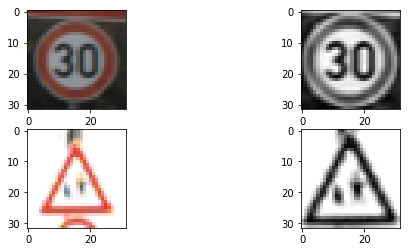

In [8]:
# Show two images before vs. after pre-processing
jj = random.randint(0, len(X_train))
kk = random.randint(0, len(X_valid))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 4))
axes[0,0].imshow(X_train[jj])
axes[0,1].imshow(Xtrain[jj,:,:,0], cmap = 'gray')
axes[1,0].imshow(X_valid[kk])
axes[1,1].imshow(Xvalid[kk,:,:,0], cmap = 'gray')

In [9]:
# Data augmentation: if the dataset has a low proportion of a certain class, then generate
# new images of that class by rotating an image from that class from -25 degrees to +25 degrees

proportions = np.zeros(43)
for i in np.unique(y_train):
    # Proportion of images of class i in full dataset
    proportions[i] = len(y_train[y_train == i]) / n_train

threshold = 0.07
for i in range(n_classes):
    # Check whether class i has fewer than threshold (6%) of images
    if proportions[i] < threshold:
        # Augment the dataset by rotating image through [-25, +25] degrees
        num_augmentations = (np.floor(threshold*n_train) - len(y_train[y_train == i])).astype(np.int32)
        print('Augmenting label %s, which is missing %s images' %(i, num_augmentations))

        p2 = np.zeros(shape = (num_augmentations,32,32,1))
        y1 = i*np.ones(num_augmentations, dtype = np.uint8)
        
        p1 = Xtrain[np.where(y_train == i)[0][0]]  # Sample image from the class
        for j in range(num_augmentations):
            # Rotate image
            p2[j] = skimage.transform.rotate(p1,-25 + 50*j/num_augmentations, resize = False)

        # Augmnet datasets by rotated images
        Xtrain = np.concatenate((Xtrain,p2), axis = 0)
        y_train = np.concatenate((y_train,y1), axis = 0)

print('\nNew train set has %s rows' %(Xtrain.shape[0]))

Augmenting label 0, which is missing 2255 images
Augmenting label 1, which is missing 455 images
Augmenting label 2, which is missing 425 images
Augmenting label 3, which is missing 1175 images
Augmenting label 4, which is missing 665 images
Augmenting label 5, which is missing 785 images
Augmenting label 6, which is missing 2075 images
Augmenting label 7, which is missing 1145 images
Augmenting label 8, which is missing 1175 images
Augmenting label 9, which is missing 1115 images
Augmenting label 10, which is missing 635 images
Augmenting label 11, which is missing 1265 images
Augmenting label 12, which is missing 545 images
Augmenting label 13, which is missing 515 images
Augmenting label 14, which is missing 1745 images
Augmenting label 15, which is missing 1895 images
Augmenting label 16, which is missing 2075 images
Augmenting label 17, which is missing 1445 images
Augmenting label 18, which is missing 1355 images
Augmenting label 19, which is missing 2255 images
Augmenting label 

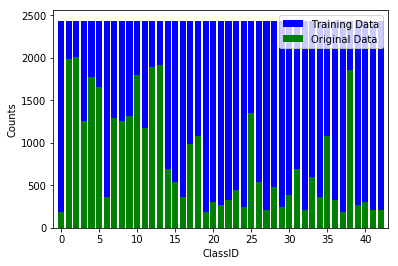

In [10]:
# Plot histograph of augmented dataset
_,train_counts = np.unique(y_train, return_counts = True)
_,train_counts_original = np.unique(train['labels'], return_counts = True)

plt.bar(range(43), train_counts, align='center',  color='b', label='Training Data')
plt.bar( np.arange( 43 ), train_counts_original, align='center', color='g', label='Original Data')
plt.xlabel('ClassID')
plt.ylabel('Counts')
plt.xlim([-1, 43])
plt.legend()

In [11]:
# Build the LeNet CNN architecture
EPOCHS = 30
BATCH_SIZE = 128

def LeNet(x):
    # Define and construct the LeNet neural network, with extra flexibility for dropouts
    # INPUT:
    # x = a grayscale image of size (N, 32, 32, 1)
    # RETURNS:
    # logits
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # LAYER 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    weights1 = tf.Variable(tf.truncated_normal((5,5,1,6), mean = mu, stddev = sigma, dtype = tf.float32))
    biases1 = tf.Variable(tf.zeros(6), dtype = tf.float32)
    strides1 = [1,1,1,1]
    
    # Run a 2D convolution and then apply dropout
    conv1 = tf.nn.conv2d(x, weights1,strides1,padding = 'VALID')
    
    # Activation using RELU
    layer1 = tf.nn.relu(tf.add(conv1,biases1))  
    
    # Pooling. Input = 28x28x6. Output = 14x14x6. HERE
    ksize1 = [1,2,2,1]
    strides_pool1 = [1,2,2,1]
    pool1 = tf.nn.max_pool(layer1, ksize = ksize1, strides = strides_pool1, padding = 'VALID')
    pool1 = tf.nn.dropout(pool1, keep_prob1)
    
    # LAYER 2: Convolutional. Output = 10x10x16.
    weights2 = tf.Variable(tf.truncated_normal((5,5,6,16), mean = mu, stddev = sigma, dtype = tf.float32))
    biases2  = tf.Variable(tf.zeros([16], dtype = tf.float32))
    strides2 = [1,1,1,1]
    conv2    = tf.nn.conv2d(pool1, weights2, strides = strides2, padding = 'VALID')
    
    # Activation.
    layer2 = tf.nn.relu(tf.add(conv2,biases2))
    
    
    # Pooling. Input = 10x10x16. Output = 5x5x16. HERE
    ksize2 = [1,2,2,1]
    strides_pool2 = [1,2,2,1]
    pool2 = tf.nn.max_pool(layer2, ksize = ksize2, strides = strides_pool2, padding = 'VALID')
    pool2 = tf.nn.dropout(pool2, keep_prob2)
    
    #Flatten. Input = 5x5x16. Output = 400.
    flat1 = flatten(pool2)
    
    # LAYER 3: Fully Connected. Input = 400. Output = 120.
    w3 = tf.Variable(tf.truncated_normal((400,120), mean = mu, stddev = sigma, dtype = tf.float32))
    b3 = tf.Variable(tf.zeros(120), dtype = tf.float32)
    
    # Activation.
    o3a = tf.add(tf.matmul(flat1,w3),b3)
    o3  = tf.nn.relu(o3a)
    o3 = tf.nn.dropout(o3,keep_prob3)
    
    # LAYER 4: Fully Connected. Input = 120. Output = 84.
    w4 = tf.Variable(tf.truncated_normal((120,84), mean = mu, stddev = sigma, dtype = tf.float32))
    b4 = tf.Variable(tf.zeros(84), dtype = tf.float32) 
    
    # Activation.
    o4a = tf.add(tf.matmul(o3,w4),b4)
    o4  = tf.nn.relu(o4a)
    o4 = tf.nn.dropout(o4,keep_prob4)
        
    # LAYER 5: Fully Connected. Input = 84. Output = 84.
    w5 = tf.Variable(tf.truncated_normal((84,43), mean = mu, stddev = sigma, dtype = tf.float32))
    b5 = tf.Variable(tf.zeros(43), dtype = tf.float32)
    logits  = tf.add(tf.matmul(o4,w5), b5)

    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
# Define variables to be used within LeNet CNN
x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Add in extra flexibility with placeholders
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)
keep_prob3 = tf.placeholder(tf.float32)
keep_prob4 = tf.placeholder(tf.float32)


# Define the optimizer 
rate = 0.001                   # Learning rate       
logits = LeNet(x)              # Run LeNet (with the placeholders as inputs)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)  # Compute cross-entropy with softmax
loss_operation = tf.reduce_mean(cross_entropy)     # This is the loss to be minimized

optimizer = tf.train.AdamOptimizer(learning_rate = rate)  # Build the optimizer
training_operation = optimizer.minimize(loss_operation)   # Run optimizer to minimize loss


In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1)) # Count number of correct predictions in this batch
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # Compute average
saver = tf.train.Saver()                                                     # Save model

def evaluate(X_data, y_data, kp1, kp2, kp3, kp4):
    # Run a TF session and compute the accuracy of each batch
    # INPUT:
    # X_data, y_data = Input training/valuation data, and corresponding labels
    # kp1,..,kp6 = keep probabilities 1-6, for dropout
    # RETURN:
    # accuracy over entire training/validation set

    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        # Feed TF CNN data in small batches of size BATCH_SIZE (global variable)
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]

        # Now run TF session to return accuracy_prediction, defined above
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, 
                                                           keep_prob1: kp1,
                                                           keep_prob2: kp2,
                                                           keep_prob3: kp3,
                                                           keep_prob4: kp4})
                                                           
        total_accuracy += (accuracy * len(batch_x))

    return total_accuracy / num_examples

In [14]:
# Run the TF session in batches and minimize loss

# Make lists to keep track of training and validation accuracy
training_accuracy   = list()
validation_accuracy = list()

with tf.Session() as sess:
    # Open a TF session and initialize variables
    sess.run(tf.global_variables_initializer())

    num_examples = len(Xtrain)
    print("Training...")
    print()

    for i in range(EPOCHS):
        # Shuffle the training set
        XX_train, yy_train = shuffle(Xtrain, y_train)

        for offset in range(0, num_examples, BATCH_SIZE):
            # Train the CNN in batches
            end = offset + BATCH_SIZE
            batch_x, batch_y = XX_train[offset:end], yy_train[offset:end]

            # Train CNN model
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,
                                                    keep_prob1: 0.9,
                                                    keep_prob2: 0.9,
                                                    keep_prob3: 1,
                                                    keep_prob4: 1})
            
        # Compute the training and validation accuracy
        ta = evaluate(Xtrain, y_train, 0.9,0.9,0.9,1)
        va = evaluate(Xvalid, y_valid, 1,1,1,1) # Recall that dropout is NOT used during validation

        # Print results
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(ta))
        print("Validation Accuracy = {:.3f}".format(va))
        print()
        validation_accuracy.append(va) 
        training_accuracy.append(ta) 
        
    # Save the model
    saver.save(sess, './lenet10')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.929
Validation Accuracy = 0.873

EPOCH 2 ...
Training Accuracy = 0.963
Validation Accuracy = 0.917

EPOCH 3 ...
Training Accuracy = 0.973
Validation Accuracy = 0.932

EPOCH 4 ...
Training Accuracy = 0.977
Validation Accuracy = 0.955

EPOCH 5 ...
Training Accuracy = 0.979
Validation Accuracy = 0.947

EPOCH 6 ...
Training Accuracy = 0.984
Validation Accuracy = 0.948

EPOCH 7 ...
Training Accuracy = 0.983
Validation Accuracy = 0.946

EPOCH 8 ...
Training Accuracy = 0.989
Validation Accuracy = 0.956

EPOCH 9 ...
Training Accuracy = 0.986
Validation Accuracy = 0.951

EPOCH 10 ...
Training Accuracy = 0.989
Validation Accuracy = 0.964

EPOCH 11 ...
Training Accuracy = 0.991
Validation Accuracy = 0.954

EPOCH 12 ...
Training Accuracy = 0.992
Validation Accuracy = 0.959

EPOCH 13 ...
Training Accuracy = 0.991
Validation Accuracy = 0.959

EPOCH 14 ...
Training Accuracy = 0.991
Validation Accuracy = 0.958

EPOCH 15 ...
Training Accuracy = 0.993
Valid

In [18]:
# Test the model on the (previously pre-processed) training set

with tf.Session() as sess:
    # Restore the model to the last checkpoint
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Evaluate the accuracy on the test set 
    test_accuracy = evaluate(Xtest, y_test,1,1,1,1) # Again, no dropout in the test run
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.953


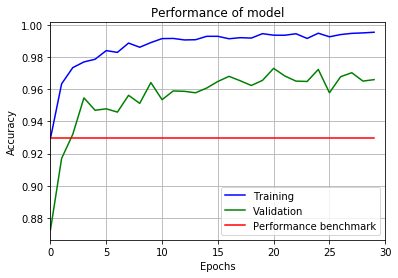

In [19]:
# Plot the accuracy of the training, validation, and test sets over EPOCHs. 
# Note: 1) the goal of the exercise was to beat 93% accuracy. 
# 2) Without any image pre-processing or LeNet modifications, accuracy = 87% 
plt.plot(range(EPOCHS), training_accuracy,  color='b', label='Training')
plt.plot(range(EPOCHS), validation_accuracy,  color='g', label='Validation')
plt.plot(range(EPOCHS), 0.93*np.ones(EPOCHS),  color='r', label='Performance benchmark')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Performance of model')
plt.xlim([0, EPOCHS])
plt.grid(True)
plt.legend()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [20]:
def prepare_image(img):
    # Pre-process the image in preparation for the CNN
    # INPUT:
    # img = any sized color image (of a roadsign)
    # RETURN:
    # a 32x32x1 greyscale image that has undergone adaptive histograph equalization
    
    p1 = cv2.resize(img,None,fx=32/img.shape[1], fy=32/img.shape[0], interpolation = cv2.INTER_CUBIC)
    p2 = cv2.cvtColor(p1, cv2.COLOR_RGB2GRAY)
    p3 = exposure.equalize_adapthist(p2,8) - 0.5
    return np.reshape(p3, (-1, 32,32,1))
    

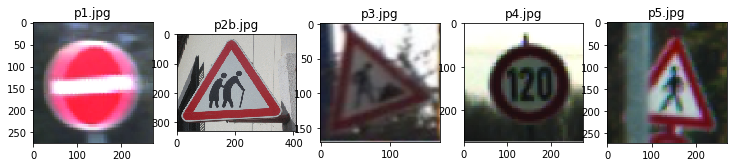

In [21]:
# Load the images (random roadsign images downloaded from public database) and plot them here.
sign_images = ['p1.jpg', 'p2b.jpg', 'p3.jpg', 'p4.jpg', 'p5.jpg']
true_classes = np.array([17, 26, 25, 8,27])               # The CORRECT labels
transformed_image = np.ndarray((len(sign_images),32,32,1)) 

# Plot the images and pre-process them
fig = plt.figure(figsize = (15,8))
for i in range(len(sign_images)):
    image = mpimg.imread('./traffic-sign-examples/' + sign_images[i])
    axes = fig.add_subplot(1,6,i+1)
    axes.imshow(image)
    axes.set_title(sign_images[i])
    transformed_image[i] = prepare_image(image)

In [22]:
def softmax(x):
    # Compute the softmax
    return (np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True))

# Classify images using model, loaded with trained weights
with tf.Session() as sess:
    # Initialize and restore model
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Feed in the pre-preocessed image(s) and get the logits. 
    logits_test = sess.run(logits, feed_dict = {x: transformed_image,
                                                  keep_prob1: 1,
                                                  keep_prob2: 1,
                                                  keep_prob3: 1,
                                                  keep_prob4: 1})
    
    # Compute the softmax of the logits
    accuracy = softmax(logits_test)
    # Classification - return the top 5 labels (with the highest probabilities)
    classification = sess.run(tf.nn.top_k(tf.constant(accuracy), k = 5))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [23]:
np.set_printoptions(precision=3)
for i in range(len(sign_images)):
    if classification.indices[i][0] == true_classes[i]:
        a = 'Correct!'
    else:
        a = 'Incorrect...'
    
    print('Image %s: Classified as image %s, true image %s. %s' %(i+1,classification.indices[i][0],true_classes[i],a))
    print('Top five ciasses are: \n %s' %(classification.indices[i][0:5]))
    print('With softmax probabilities \n %s' %(classification.values[i][0:5]))
    print('\n\n')
          
          
num_right = 100*np.sum(classification.indices[:,0] == true_classes)/len(sign_images)
print('\nInference accuracy is %.1f ' %(num_right))

Image 1: Classified as image 17, true image 17. Correct!
Top five ciasses are: 
 [17 14  9 36 34]
With softmax probabilities 
 [  1.000e+00   4.001e-11   1.132e-13   1.077e-14   4.776e-15]



Image 2: Classified as image 28, true image 26. Incorrect...
Top five ciasses are: 
 [28 27 18 20  5]
With softmax probabilities 
 [  9.999e-01   2.354e-05   1.412e-05   9.135e-06   6.040e-06]



Image 3: Classified as image 25, true image 25. Correct!
Top five ciasses are: 
 [25 12 26  1 20]
With softmax probabilities 
 [  1.000e+00   6.490e-07   1.227e-07   5.222e-08   4.815e-08]



Image 4: Classified as image 8, true image 8. Correct!
Top five ciasses are: 
 [8 7 5 2 1]
With softmax probabilities 
 [  6.158e-01   2.677e-01   1.164e-01   6.826e-05   9.469e-06]



Image 5: Classified as image 27, true image 27. Correct!
Top five ciasses are: 
 [27 11 28 39 18]
With softmax probabilities 
 [  8.362e-01   1.344e-01   2.890e-02   4.561e-04   8.531e-05]




Inference accuracy is 80.0 


Image 4 correctly classified as image 8 with 0.615845 probability


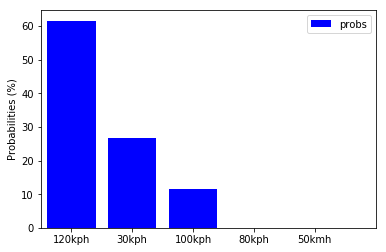

In [26]:
# Consider the fourth image (!20 kph limit sign). Model correctly predicted it (70% probability, but classified 
# other signs with 29% probability. Other predictions had in total <1% probability

print('Image %s correctly classified as image %s with %s probability' 
      %(4,classification.indices[3][0],classification.values[3][0]))

# Plot barchart
plt.bar(range(5), 100*classification.values[3][0:5], align='center',  color='b', label = 'probs')
plt.ylabel('Probabilities (%)')
plt.xlim([-0.5, 5])
plt.xticks(range(5), ['120kph', '30kph', '100kph','80kph','50kmh'])
plt.legend()


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images



In [27]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
weights1 = tf.Variable(tf.truncated_normal((5,5,1,6), mean = mu, stddev = sigma, dtype = tf.float32))
biases1 = tf.Variable(tf.zeros(6), dtype = tf.float32)
strides1 = [1,1,1,1]
conv1 = tf.nn.conv2d(x, weights1,strides1,padding = 'VALID')

# TODO: Activation.
layer1 = tf.nn.relu(tf.add(conv1,biases1))  

# TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
ksize1 = [1,2,2,1]
strides_pool1 = [1,2,2,1]
pool1 = tf.nn.max_pool(layer1, ksize = ksize1, strides = strides_pool1, padding = 'VALID')

pool1 = tf.nn.dropout(pool1, keep_prob2)

# TODO: Layer 2: Convolutional. Output = 10x10x16.
weights2 = tf.Variable(tf.truncated_normal((5,5,6,16), mean = mu, stddev = sigma, dtype = tf.float32))
biases2  = tf.Variable(tf.zeros([16], dtype = tf.float32))
strides2 = [1,1,1,1]
conv2    = tf.nn.conv2d(pool1, weights2, strides = strides2, padding = 'VALID')

# TODO: Activation.
layer2 = tf.nn.relu(tf.add(conv2,biases2))


# TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
ksize2 = [1,2,2,1]
strides_pool2 = [1,2,2,1]
pool2 = tf.nn.max_pool(layer2, ksize = ksize2, strides = strides_pool2, padding = 'VALID')
pool2 = tf.nn.dropout(pool2, keep_prob2)

# TODO: Flatten. Input = 5x5x16. Output = 400.
flat1 = flatten(pool2)

# TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
w3 = tf.Variable(tf.truncated_normal((400,120), mean = mu, stddev = sigma, dtype = tf.float32))
b3 = tf.Variable(tf.zeros(120), dtype = tf.float32)

# TODO: Activation.
o3a = tf.add(tf.matmul(flat1,w3),b3)
o3  = tf.nn.relu(o3a)

o3 = tf.nn.dropout(o3,keep_prob3)
# TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
w4 = tf.Variable(tf.truncated_normal((120,84), mean = mu, stddev = sigma, dtype = tf.float32))
b4 = tf.Variable(tf.zeros(84), dtype = tf.float32) 

# TODO: Activation.
o4a = tf.add(tf.matmul(o3,w4),b4)
o4  = tf.nn.relu(o4a)
o3 = tf.nn.dropout(o3,keep_prob4)

# TODO: Layer 5: Fully Connected. Input = 84. Output = 84.
w5 = tf.Variable(tf.truncated_normal((84,43), mean = mu, stddev = sigma, dtype = tf.float32))
b5 = tf.Variable(tf.zeros(43), dtype = tf.float32)

In [62]:
### Visualize the network's feature maps.
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    img = prepare_image(image_input)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : img, 
                                                  keep_prob1: 0.9,
                                                  keep_prob2: 0.9,
                                                  keep_prob3: 1,
                                                  keep_prob4: 1})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

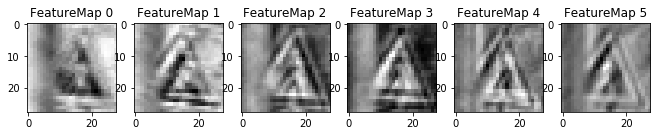

In [59]:
image = mpimg.imread('./traffic-sign-examples/' + sign_images[4])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
#     outputFeatureMap(image, layer1)
    outputFeatureMap(image, conv1)

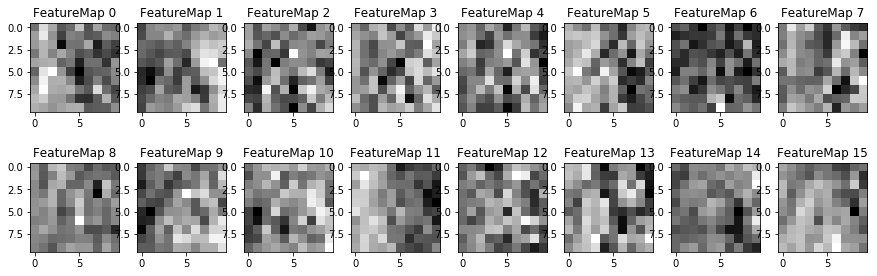

In [60]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(image, conv2)